In [1]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
#Install Additional Libraries
!pip install keras_cv
!pip install dropconnect-tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 58.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dropconnect-tensorflow: filename=dropconnect_tensorflow-0.1.1-py3-none-any.whl size=4639 sha256=1ea9b7e017be1a60ba8a8b4ae420f01a7ae186577cef6a20fa734c12d5906e14
  Stored in directory: /root/.cache/pip/wheels/7e/4a/e5/266cd645dbc3573352598ba045a07b58db04fc73b8cfab99ae
Successfully built dropconnect-tensorflow


In [3]:
#Import Libraries
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
import random
from sklearn.model_selection import train_test_split
from cv2 import GaussianBlur, threshold, THRESH_BINARY
from skimage.segmentation import clear_border

mc_image_dir = '/content/drive/MyDrive/CV_datasets/NLM Chest X-Rays/Montgomery Images/'
shenzen_image_dir = '/content/drive/MyDrive/CV_datasets/NLM Chest X-Rays/Shenzen Images/'
mc_mask_dir ='/content/drive/MyDrive/CV_datasets/NLM Chest X-Rays/Montgomery Masks/'
shenzen_mask_dir = '/content/drive/MyDrive/CV_datasets/NLM Chest X-Rays/Shenzen Masks/'

mc_image_filenames = os.listdir(mc_image_dir)
mc_mask_filenames = os.listdir(mc_mask_dir)
shenzen_image_filenames = os.listdir(shenzen_image_dir)
shenzen_mask_filenames = os.listdir(shenzen_mask_dir)

In [4]:
def sorted_paths(image_filenames, mask_filenames, image_dir, mask_dir):
  image_paths = []
  mask_paths = []
  for image_name in image_filenames:
      for mask_name in mask_filenames:
          if image_name[7:12] == mask_name[7:12]:
              image_paths.append(os.path.join(image_dir, image_name))
              mask_paths.append(os.path.join(mask_dir, mask_name))
  assert len(image_paths) == len(mask_paths)
  return image_paths, mask_paths

def load_data(image_path, mask_path, size=(128,128)):
  #Load Image
  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image, 1)
  image = tf.image.resize(image, size)
  image = tf.cast(image, tf.float32) / 255.0

  #Load Mask
  mask = tf.io.read_file(mask_path)
  mask = tf.image.decode_png(mask, 1)
  mask = tf.image.resize(mask, size)
  mask = tf.cast(mask, tf.float32) / 255.0
  return image, mask

def data_visualiser(image):
  image_np = image.numpy()
  print(f"Array Shape is {np.shape(image_np)}")
  plt.imshow(image_np)
  plt.axis('off')
  plt.show()

def train_test_split(sorted_image_paths, sorted_mask_paths, split_ratio=0.2):
  assert len(sorted_image_paths) == len(sorted_mask_paths)
  sorted_paths = list(zip(sorted_image_paths, sorted_mask_paths))
  split_threshold = int((1 - split_ratio) * len(sorted_paths))
  random.shuffle(sorted_paths)
  train_data_paths = sorted_paths[:split_threshold]
  test_data_paths = sorted_paths[split_threshold+1:]
  train_image_paths, train_mask_paths = zip(*train_data_paths)
  test_image_paths, test_mask_paths = zip(*test_data_paths)
  #Convert to lists
  train_image_paths = list(train_image_paths)
  train_mask_paths = list(train_mask_paths)
  test_image_paths = list(test_image_paths)
  test_mask_paths = list(test_mask_paths)
  return train_image_paths, train_mask_paths, test_image_paths, test_mask_paths

In [5]:
mc_image_paths, mc_mask_paths = sorted_paths(mc_image_filenames, mc_mask_filenames, mc_image_dir, mc_mask_dir)
shenzen_image_paths, shenzen_mask_paths = sorted_paths(shenzen_image_filenames, shenzen_mask_filenames, shenzen_image_dir, shenzen_mask_dir)
sorted_image_paths = mc_image_paths + shenzen_image_paths
sorted_mask_paths = mc_mask_paths + shenzen_mask_paths
train_image_paths, train_mask_paths, test_image_paths, test_mask_paths = train_test_split(sorted_image_paths, sorted_mask_paths)

train_image_paths_tensor = tf.data.Dataset.from_tensor_slices(train_image_paths)
train_mask_paths_tensor = tf.data.Dataset.from_tensor_slices(train_mask_paths)
train_dataset = tf.data.Dataset.zip(train_image_paths_tensor, train_mask_paths_tensor)
train_dataset = train_dataset.map(load_data)
print(len(train_dataset))

test_image_paths_tensor = tf.data.Dataset.from_tensor_slices(test_image_paths)
test_mask_paths_tensor = tf.data.Dataset.from_tensor_slices(test_mask_paths)
test_dataset = tf.data.Dataset.zip(test_image_paths_tensor, test_mask_paths_tensor)
test_dataset = test_dataset.map(load_data)
print(len(test_dataset))

563
140


/content/drive/MyDrive/CV_datasets/NLM Chest X-Rays/Shenzen Images/CHNCXR_0132_0.png
Array Shape is (128, 128, 1)


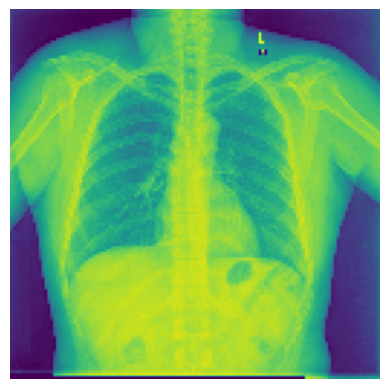

/content/drive/MyDrive/CV_datasets/NLM Chest X-Rays/Shenzen Masks/CHNCXR_0132_0_mask.png
Array Shape is (128, 128, 1)


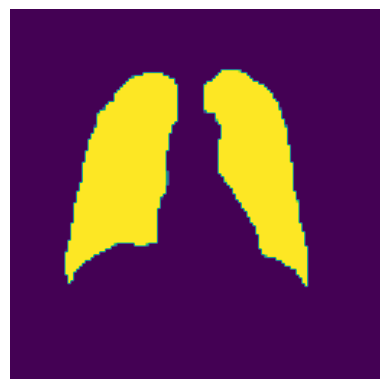

In [6]:
#Visualise Training Data
index = random.randint(0, len(train_image_paths))
sample_image_path = train_image_paths[index]
sample_mask_path = train_mask_paths[index]
sample_image, sample_mask = load_data(sample_image_path, sample_mask_path)
print(sample_image_path)
data_visualiser(sample_image)
print(sample_mask_path)
data_visualiser(sample_mask)

In [7]:
#Define Model
import keras
import tensorflow_probability as tfp
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, MaxPooling2D, multiply
from dropconnect_tensorflow import DropConnectConv2D
from keras_cv.layers import DropBlock2D
from keras_cv.layers import RandomSharpness
from keras.models import Model

def variational_unet(input_size=(128,128,1), filters_init=32, activation_fn='relu', kernel_init='he_normal', drop_rate=0.2, block_size=7):
  #Define Double Convolution Layer
  def conv_layer(filters, inputs, use_spatial_attention=False):
    x = Conv2D(filters, (3,3), activation=None, padding='same', kernel_initializer=kernel_init)(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation_fn)(x)
    if use_spatial_attention:
      x = spatial_attention(x)
    x = Conv2D(filters, (3,3), activation=None, padding='same', kernel_initializer=kernel_init)(x)
    x = BatchNormalization()(x)
    x = Activation(activation_fn)(x)
    return x

  def variational_layer(filters, inputs):
    x = tfp.layers.Convolution2DFlipout(filters, (3,3), activation=None, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation_fn)(x)
    x = tfp.layers.Convolution2DFlipout(filters, (3,3), activation=None, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation_fn)(x)
    return x

  def spatial_attention(input_feature):
    """TensorFlow 2 Implementation of Convolutional Block Attention Module - https://arxiv.org/pdf/1807.06521.pdf """
    kernel_size = 7
    avg_pool = tf.reduce_mean(input_feature, axis=[3], keepdims=True)
    assert avg_pool.shape[-1] == 1
    max_pool = tf.reduce_max(input_feature, axis=[3], keepdims=True)
    assert avg_pool.shape[-1] == 1
    concat = concatenate([avg_pool, max_pool], axis=3)
    assert concat.shape[-1] == 2
    conv_layer = Conv2D(filters=1,
                        kernel_size = (kernel_size, kernel_size),
                        activation=None,
                        padding='same',
                        kernel_initializer = kernel_init,
                        use_bias=False)(concat)
    assert conv_layer.shape[-1] == 1
    sigmoid_output = tf.keras.activations.sigmoid(conv_layer)
    return multiply([input_feature, sigmoid_output])

  inputs = Input(input_size)
  enc_layer1 = conv_layer(filters_init, inputs)
  pool1 = MaxPooling2D((2,2))(enc_layer1)

  enc_layer2 = conv_layer(2*filters_init, pool1)
  pool2 = MaxPooling2D((2,2))(enc_layer2)

  enc_layer3 = conv_layer(4*filters_init, pool2)
  pool3 = MaxPooling2D((2,2))(enc_layer3)

  enc_layer4 = conv_layer(8*filters_init, pool3)
  pool4 = MaxPooling2D((2,2))(enc_layer4)

  enc_layer5 = conv_layer(16*filters_init, pool4, use_spatial_attention=True)

  dec_layer4 = concatenate([Conv2DTranspose(8*filters_init, (2, 2), strides=(2, 2), padding='same')(enc_layer5), enc_layer4], axis=3)
  dec_layer4 = variational_layer(8*filters_init, dec_layer4)

  dec_layer3 = concatenate([Conv2DTranspose(4*filters_init, (2, 2), strides=(2, 2), padding='same')(dec_layer4), enc_layer3], axis=3)
  dec_layer3 = variational_layer(4*filters_init, dec_layer3)

  dec_layer2 = concatenate([Conv2DTranspose(2*filters_init, (2, 2), strides=(2, 2), padding='same')(dec_layer3), enc_layer2], axis=3)
  dec_layer2 = variational_layer(2*filters_init, dec_layer2)

  dec_layer1 = concatenate([Conv2DTranspose(filters_init, (2, 2), strides=(2, 2), padding='same')(dec_layer2), enc_layer1], axis=3)
  dec_layer1 = conv_layer(filters_init, dec_layer1)

  out_layer = Conv2D(1, (1,1), activation='sigmoid')(dec_layer1)

  return Model(inputs=[inputs], outputs=[out_layer])


Using TensorFlow backend


In [8]:
#Define Custom Callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback
reduce_lr = ReduceLROnPlateau(monitor = 'binary_accuracy',
                              factor = 0.5,
                              patience = 8,
                              min_lr = 1e-5,
                              verbose = 1)

class AnnealingCallback(tf.keras.callbacks.Callback):
    def __init__(self,beta,name,total_epochs):
        self.beta=beta
        self.name=name
        self.total_epochs=total_epochs

    def on_epoch_end(self,epoch,logs={}):

        R=0.5
        if self.name=="normal":
            pass
        elif self.name=="monotonic":

            new_value=epoch/float(self.total_epochs)*R
            if new_value>1:
                new_value=1
            tf.keras.backend.set_value(self.beta,new_value)
            print("\n Current beta: "+str(tf.keras.backend.get_value(self.beta)))
        elif self.name=="cyclical":
            T=self.total_epochs
            M=5
            frac=int(self.total_epochs/M)
            tt=((epoch)%frac)/float(frac)

            new_value=tt
            if new_value>1:
                new_value=1
            tf.keras.backend.set_value(self.beta,new_value)
            print("\n Current beta: "+str(tf.keras.backend.get_value(self.beta)))

#Define Variational Loss
def variational_free_energy_loss(y_true, y_pred, batch_size=32):
    # KL Divergence should be applied once per epoch only, so scale_factor should be num_samples / batch_size.
    scale_factor = tf.cast(len(train_dataset)/batch_size, tf.float32)
    kl = sum(model.losses)/scale_factor
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    loss = bce + tf.keras.backend.get_value(beta) * kl
    return loss

In [9]:
#Initialize Beta
beta = tf.Variable(0.001, trainable=True, dtype=tf.float32)

In [10]:
from keras.optimizers import Adam
batch_size = 32
tf.config.run_functions_eagerly(True)
model = variational_unet()
model.compile(optimizer= Adam(learning_rate=2e-4), loss=variational_free_energy_loss, metrics=['binary_accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         320       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 128, 32)         0         ['batch_normalization[0][0

In [11]:
#Set Number of Training Epochs
num_epochs = 50
#Setup Cyclic Annealing Callback
cyclic_annealing = AnnealingCallback(beta, 'cyclical', num_epochs)

In [12]:
train_data = train_dataset.batch(batch_size)
train_hist = model.fit(train_data,epochs=num_epochs, callbacks=[reduce_lr, cyclic_annealing])


Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 5873678.0000 - binary_accuracy: 0.7590
 Current beta: 0.0
18/18 [==============================] - 91s 4s/step - loss: 5873678.0000 - binary_accuracy: 0.7590 - lr: 2.0000e-04
Epoch 2/50
18/18 [==============================] - ETA: 0s - loss: 5864568.5000 - binary_accuracy: 0.8795
 Current beta: 0.1
18/18 [==============================] - 14s 716ms/step - loss: 5864568.5000 - binary_accuracy: 0.8795 - lr: 2.0000e-04
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 5889108.0000 - binary_accuracy: 0.9413
 Current beta: 0.2
18/18 [==============================] - 14s 714ms/step - loss: 5889108.0000 - binary_accuracy: 0.9413 - lr: 2.0000e-04
Epoch 4/50
18/18 [==============================] - ETA: 0s - loss: 5913563.5000 - binary_accuracy: 0.9571
 Current beta: 0.3
18/18 [==============================] - 15s 771ms/step - loss: 5913563.5000 - binary_accuracy: 0.9571 - lr: 2.0000e-04
Epoch 5/50
18/18 [=

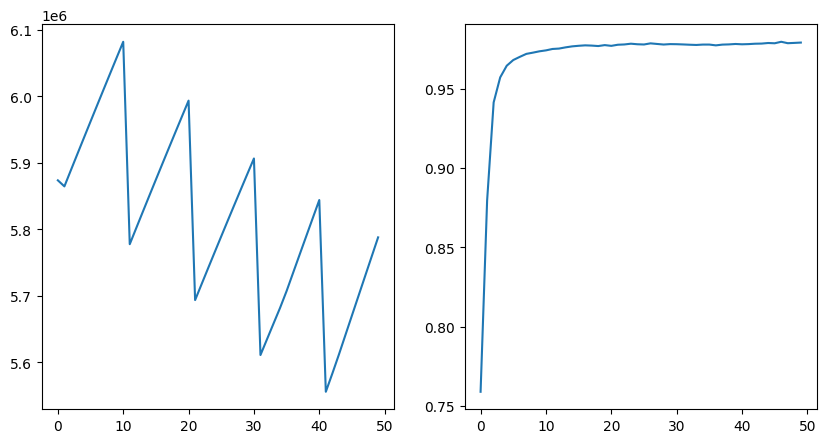

In [13]:
#Training Curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(train_hist.history['loss'], '-', label = 'Loss')
ax2.plot(train_hist.history['binary_accuracy'], label='Binary Accuracy')


In [14]:
#Batch test data
test_data_batched = test_dataset.batch(batch_size)
predictions = model.predict(test_data_batched)

#Apply Gaussian Blur Filter to Predicted Masks
def GaussianFilter(image, kernel_size=(5,5), sigma=1.0):
  smoothed_mask = GaussianBlur(image, kernel_size, sigma)
  return smoothed_mask

def ThresholdImage(image, threshold_value):
  retval, thresholded_image = threshold(image, threshold_value, 1.0, THRESH_BINARY)
  return thresholded_image

5/5 [==============================] - 19s 4s/step


/content/drive/MyDrive/CV_datasets/NLM Chest X-Rays/Shenzen Masks/CHNCXR_0150_0_mask.png


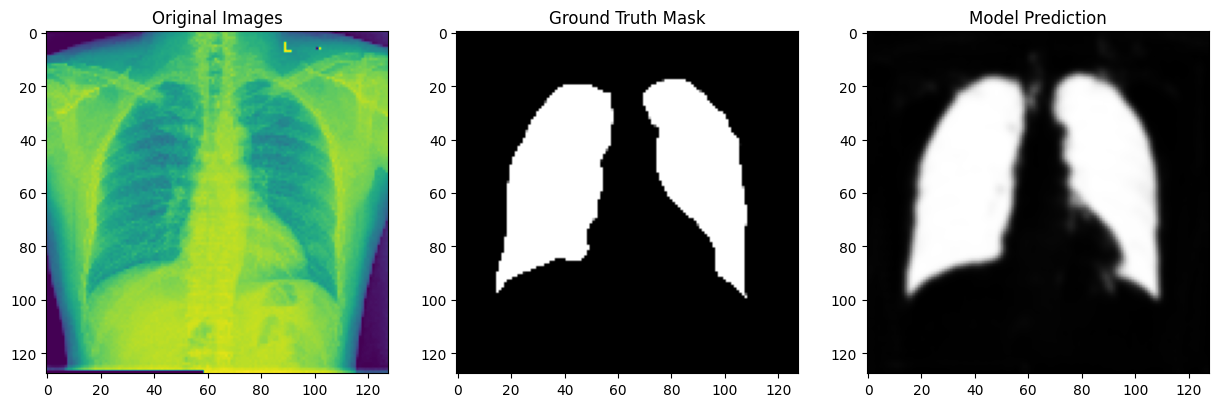

/content/drive/MyDrive/CV_datasets/NLM Chest X-Rays/Shenzen Masks/CHNCXR_0178_0_mask.png


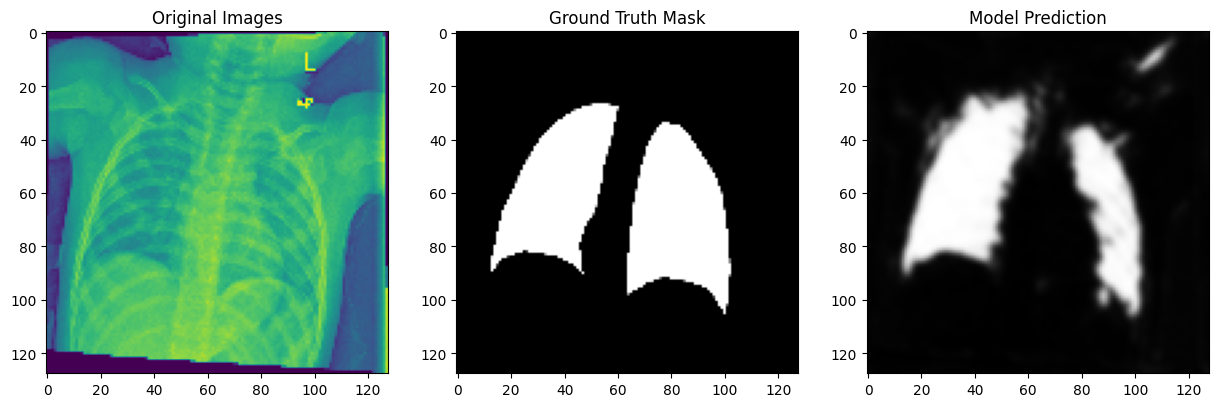

/content/drive/MyDrive/CV_datasets/NLM Chest X-Rays/Shenzen Masks/CHNCXR_0426_1_mask.png


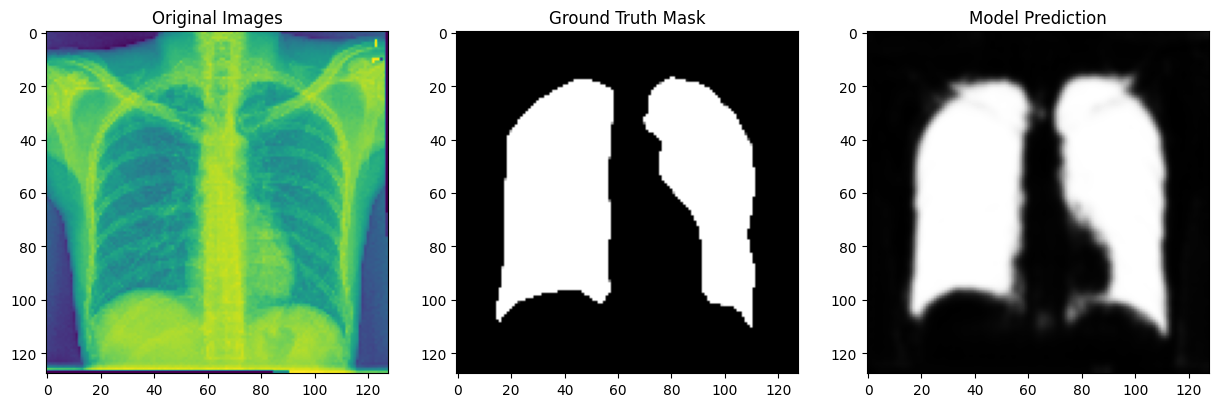

/content/drive/MyDrive/CV_datasets/NLM Chest X-Rays/Shenzen Masks/CHNCXR_0628_1_mask.png


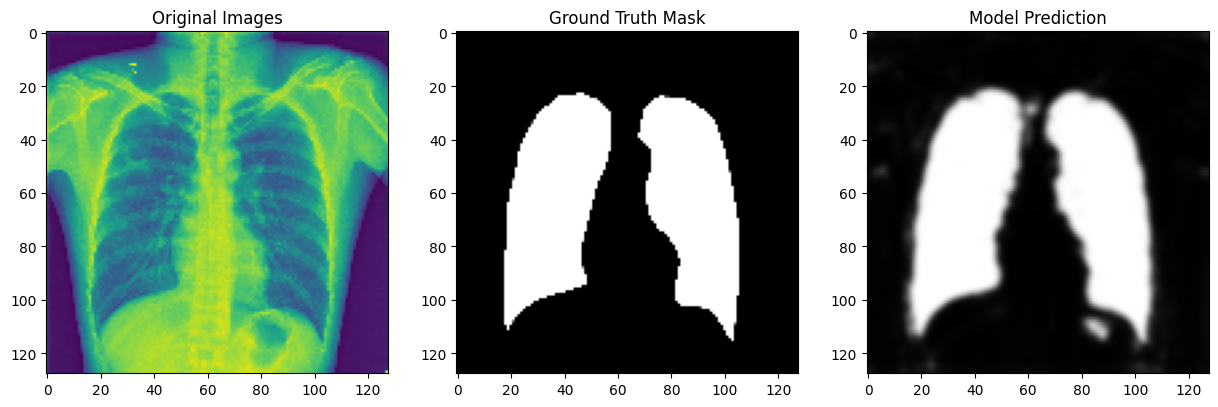

/content/drive/MyDrive/CV_datasets/NLM Chest X-Rays/Shenzen Masks/CHNCXR_0600_1_mask.png


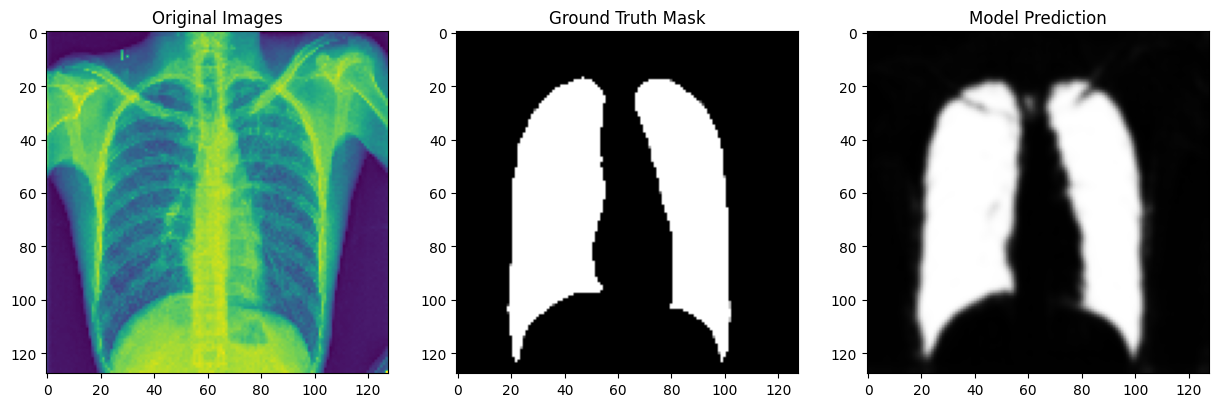

In [15]:
#Visualise Results
for i in range(0,5):
  test_image_element, test_mask_element = load_data(test_image_paths[i], test_mask_paths[i])

  #Convert to NumPy Arrays
  test_image = test_image_element.numpy()
  test_mask = test_mask_element.numpy()
  prediction = predictions[i]
  smoothed_prediction = GaussianFilter(prediction)


  plt.figure(figsize=(15, 5))

  # Original Image
  plt.subplot(1, 3, 1)
  plt.imshow(test_image)
  plt.title(f"Original Images")
  print(f"{test_mask_paths[i]}")

  # Ground Truth Mask
  plt.subplot(1, 3, 2)
  plt.imshow(test_mask, cmap='gray')
  plt.title('Ground Truth Mask')

  # Model Prediction
  plt.subplot(1, 3, 3)
  plt.imshow(smoothed_prediction, cmap='gray')
  plt.title('Model Prediction')

  plt.show()


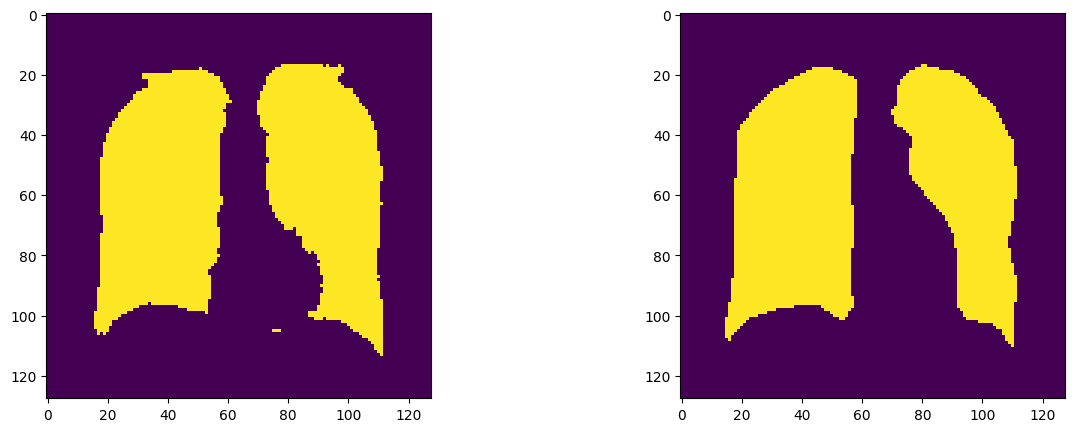

0.9394051357842232


In [16]:
from sklearn.metrics import f1_score
img_index = 2
predicted_mask = predictions[img_index]
_, ground_truth_mask = load_data(test_image_paths[img_index], test_mask_paths[img_index])
ground_truth_mask = ground_truth_mask.numpy()

#Convert to Binary
threshold = 0.5
predicted_binary = (predicted_mask > threshold).astype(np.uint8)
ground_truth_binary = (ground_truth_mask > threshold).astype(np.uint8)

assert np.shape(predicted_binary) == np.shape(ground_truth_binary)

#Display Images as a sanity check
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.imshow(predicted_binary)
plt.subplot(1,2,2)
plt.imshow(ground_truth_binary)
plt.show()

f1 = f1_score(ground_truth_binary.flatten(), predicted_binary.flatten())
print(f1)

In [17]:
#Uncertanity Estimation
def Entropy(X, axis=-1):
  return -1* np.sum(X * np.log(X+1E-12), axis=axis)

def calc_uncertainity(predictions):
  mean = np.mean(predictions, axis=0)
  std_dev = np.std(predictions, axis=0)
  entropy=Entropy(np.mean(predictions, axis=0),axis=-1)
  entropy_exp = np.mean(Entropy(predictions, axis=1))
  mutual_info = entropy - entropy_exp
  std_dev = np.std(predictions, 0)
  aleatoric = np.mean(predictions*(1-predictions), axis=0)
  epistemic = np.mean(predictions**2, axis=0) - np.mean(predictions, axis=0)**2
  overall= aleatoric + epistemic
  return mean, std_dev, entropy, mutual_info, std_dev, aleatoric, epistemic , overall

def inference(model,image,N=20,threshold=0.05):
  image_batched = np.expand_dims(image, axis=0)
  #Perform N stochastic forward passes
  predicted_masks = []
  for i in range(0,N):
    prediction = model.predict(image_batched)
    predicted_masks.append(prediction)
  predicted_masks = np.array(predicted_masks)
  mean, std_dev, entropy, mutual_info, std_dev, aleatoric, epistemic , overall = calc_uncertainity(predicted_masks)
  uncert_prediction = np.where(overall > threshold*np.max(overall), 1, 0)
  return np.squeeze(mean), np.squeeze(std_dev), np.squeeze(uncert_prediction), np.squeeze(aleatoric), np.squeeze(epistemic)

In [18]:
#Inference
for index, pair in enumerate(test_dataset):
    if index == img_index:
        test_image, test_mask = pair
        break

# Add a batch dimension to the image
np.shape(test_image)


TensorShape([128, 128, 1])

In [19]:
mean, std_dev, overall, aleatoric, epistemic = inference(model, test_image)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 180ms/step


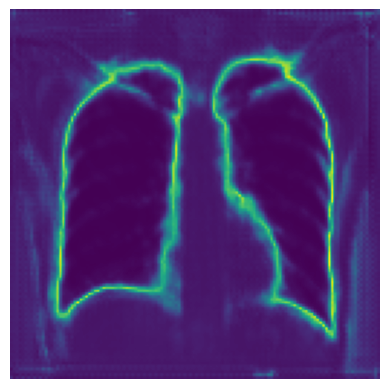

In [22]:
plt.imshow(aleatoric)
plt.axis('off')
plt.show()

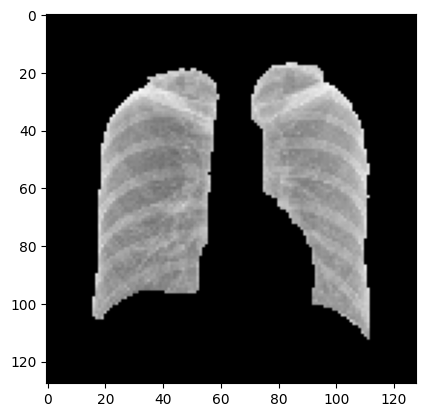

In [23]:
import cv2
def overlay_data(image_array, mask_array, threshold_value=0.5):
  binary_mask = (mean >= threshold_value).astype(np.uint8)
  mask = binary_mask > 0
  overlay = np.zeros_like(image_array)
  overlay[mask] = image_array[mask]
  return overlay

image = test_image.numpy()
ground_truth_mask = test_mask.numpy()
overlay = overlay_data(image, mean)
plt.imshow(overlay, cmap='gray')

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 180ms/step
Uncertanity (Aleatoric + Epistemic): 0.76922607421875


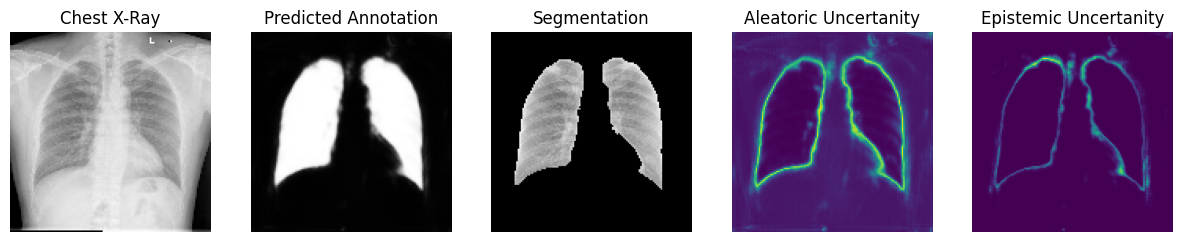

(128, 128) (128, 128)
F1 Score: 0.955360455051317


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 187ms/step
Uncertanity (Aleatoric + Epistemic): 0.76922607421875


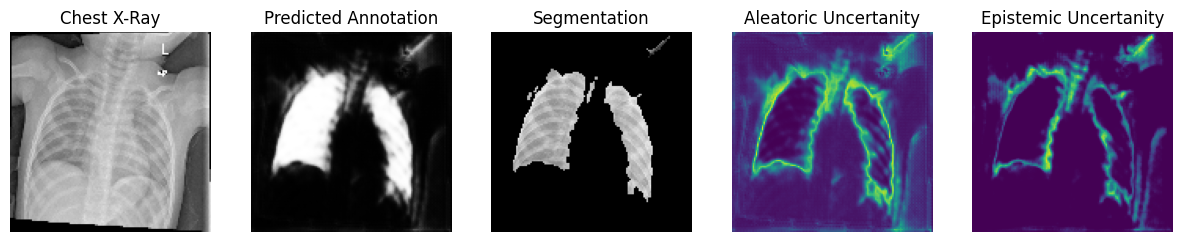

(128, 128) (128, 128)
F1 Score: 0.8089143201325102


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 177ms/step
Uncertanity (Aleatoric + Epistemic): 0.76922607421875


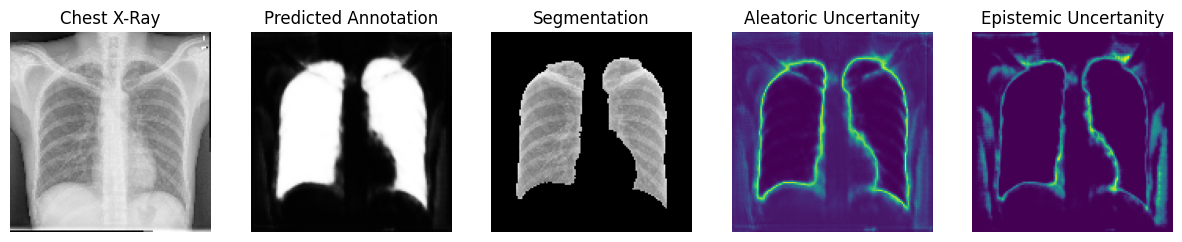

(128, 128) (128, 128)
F1 Score: 0.9525706697021437


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 188ms/step
Uncertanity (Aleatoric + Epistemic): 0.76922607421875


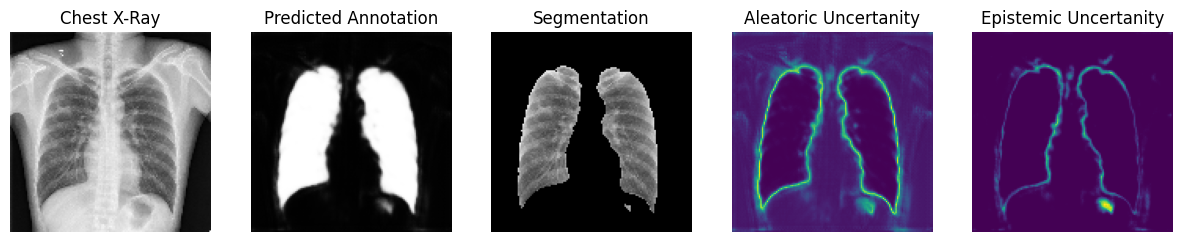

(128, 128) (128, 128)
F1 Score: 0.9711664482306684


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 180ms/step
Uncertanity (Aleatoric + Epistemic): 0.76922607421875


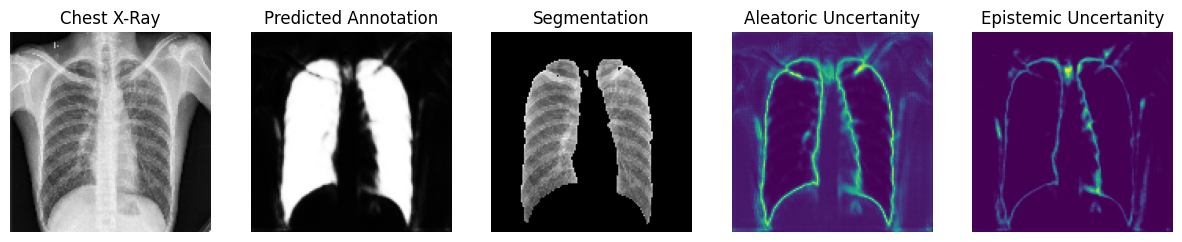

(128, 128) (128, 128)
F1 Score: 0.9666837519220911


In [24]:
from sklearn.metrics import f1_score
#Visualise Results
for i in range(0,5):
  test_image_element, test_mask_element = load_data(test_image_paths[i], test_mask_paths[i])

  #Convert to NumPy Arrays
  image = test_image_element.numpy()
  ground_truth_mask = test_mask_element.numpy()

  mean, _, prediction, aleatoric, epistemic = inference(model, image)

  overlay = overlay_data(image, mean)

  plt.figure(figsize=(15, 5))

  #CXR
  plt.subplot(1, 5, 1)
  plt.axis('off')
  plt.imshow(image, cmap='gray')
  plt.title('Chest X-Ray')

  #Predicted Mask
  plt.subplot(1, 5, 2)
  plt.axis('off')
  plt.imshow(mean, cmap='gray')
  plt.title('Predicted Annotation')

  plt.subplot(1, 5, 3)
  plt.axis('off')
  plt.imshow(overlay, cmap='gray')
  plt.title('Segmentation')

  #Aleatoric Uncertanity
  plt.subplot(1, 5, 4)
  plt.axis('off')
  plt.imshow(aleatoric)
  plt.title(f"Aleatoric Uncertanity")

  #Epistemic Uncertanity
  plt.subplot(1, 5, 5)
  plt.axis('off')
  plt.imshow(epistemic)
  plt.title(f"Epistemic Uncertanity")



  plt.show()

  #Convert to Binary
  threshold = 0.5
  predicted_binary = (mean > threshold).astype(np.uint8)
  ground_truth_binary = (ground_truth_mask > threshold).astype(np.uint8)
  ground_truth_binary = np.squeeze(ground_truth_binary)

  print(np.shape(predicted_binary), np.shape(ground_truth_binary))
  assert np.shape(predicted_binary) == np.shape(ground_truth_binary)

  #Calculate Metrics
  f1 = f1_score(ground_truth_binary.flatten(), predicted_binary.flatten())
  print(f"F1 Score: {f1}")

In [25]:
#F1 Score Performance: Whole Test Dataset
f1_scores = []
for i in range(0,len(test_image_paths)):
  test_image_element, test_mask_element = load_data(test_image_paths[i], test_mask_paths[i])

  #Convert to NumPy Arrays
  test_image = test_image_element.numpy()
  test_mask = test_mask_element.numpy()
  prediction = predictions[i]

  #Convert to Binary
  threshold = 0.5
  predicted_binary = (mean > threshold).astype(np.uint8)
  ground_truth_binary = (ground_truth_mask > threshold).astype(np.uint8)
  ground_truth_binary = np.squeeze(ground_truth_binary)

  assert np.shape(predicted_binary) == np.shape(ground_truth_binary)

  #Calculate Metrics
  f1 = f1_score(ground_truth_binary.flatten(), predicted_binary.flatten())
  f1_scores.append(f1)

f1_scores = np.array(f1_scores)
print(f"Mean F1 Score {np.mean(f1_scores)}")

Mean F1 Score 0.9666837519220911
